In [14]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count
from finite_tight_binding import TightBindingHamiltonian
import scipy.constants as spc

In [25]:
class EffectiveMass(TightBindingHamiltonian):
    def __init__(self, N, sparseSetting = False):
        super().__init__(N)
        self.sparse_setting = True
        
        # sparse parameter
        self.sigma = 0.55 # start values of eigenvalues
        self.eigenRange = 10 # amount of computed eigenvalues (initially 10)
        self.cbm = {}
        self.vbm = {}
        self.cbmValue = [0,np.inf]
        self.vbmValue = [0, -np.inf]
        self.Nk = 30
        self.a = 5.431e-10

        
    def make_mp_grid(self,Nk):
        """Return an (Nk3, 3) array of fractional k-vectors (0 … 1) in the 1st BZ."""
        shifts = np.linspace(0, 1, Nk, endpoint=False) + 0.5/Nk   
        klist  = np.array(list(product(shifts, repeat=2)))        

        return klist                                             
    # helper method 
    def frac_shift(self, k_frac, delta):
        return (k_frac + delta) % 1.0

    
    #--------------------------Sparse calculations-----------------------------
    def analyzeEnergyRange(self, k, energies, effectiveMassCalc=False):
        energies = sorted(energies)
        """This function does the brunt of sparse analysis"""
        if (min(energies)> 0 or max(energies) < 0):
            self.eigenRange += 5
            self.analyzeEnergyRange(self, self.create_tight_binding_sparse(k, self.N, sigma= self.sigma, eigRange = self.eigenRange)[0], True)
        
        largest_diff = [0,1,abs(energies[1] - energies[0])]
        for i,val in enumerate(energies[:-1]):
            diff = val - energies[i + 1]
            if abs(diff) > largest_diff[-1]:
                largest_diff[0] = i
                largest_diff[1] = i + 1
                largest_diff[-1] = abs(diff)
                
        if effectiveMassCalc==False:
            self.cbm[tuple(k)] = [energies[largest_diff[1]], self.sigma, self.eigenRange]
            if (self.cbmValue[-1] > energies[largest_diff[1]]):
                self.cbmValue = [k, energies[largest_diff[1]]]
            self.vbm[tuple(k)] = [energies[largest_diff[0]], self.sigma, self.eigenRange]
            if (abs(self.vbmValue[-1]) > abs(energies[largest_diff[0]])):
                self.vbmValue = [k, energies[largest_diff[0]]]
        else:
            return energies[largest_diff[1]] 
        self.sigma = energies[largest_diff[0]] + largest_diff[-1] / 2 # exact center of band gap
        self.eigenRange = 5 # in case we overshoot 
        
    
    def eval_k_sparse(self, k_frac):
        eigenvalues, H = self.create_tight_binding_sparse(np.array([0,0]), sigma=self.sigma, eigRange= self.eigenRange)
        self.analyzeEnergyRange(k_frac, eigenvalues)
    
    def determineInitialSparseSettings(self):
        k = np.array([0,0])
        eigenvalues, H = self.create_tight_binding_sparse(np.array([0,0]), sigma=self.sigma, eigRange= self.eigenRange)
        self.analyzeEnergyRange(k, eigenvalues)
    
    def scan_full_BZ(self, Nk=30, store_all=True, n_jobs=None, a=5.431e-10, res_factor=4):
        self.Nk = Nk
        klist = self.make_mp_grid(Nk)
        #print(klist)
        for k in klist:
            self.eval_k_sparse(k)
    
    def calculateEffectiveMass(self, resolution = 4):
       
        startk = self.cbmValue[0]
        print(startk)
        energy, sigma, erange = self.cbm[tuple(startk)]
        erange += 3
        E = lambda k: self.analyzeEnergyRange(k, self.create_tight_binding_sparse(k, self.N, sigma = sigma, eigRange = erange)[0], effectiveMassCalc = True)
        
        delta_frac = 1.0 / (self.Nk* resolution)        # we want a finer mesh size
        dk = (2*np.pi / self.a) * delta_frac                       


        k0 = np.asarray(startk, float)

        #shift 
        ei = np.eye(2)

        # Hessian 
        H = np.zeros((2,2))
        for i in range(2):
            # second derivative along axis i
            kp = self.frac_shift(k0,  +delta_frac * ei[i])
            km = self.frac_shift(k0,  -delta_frac * ei[i])
            H[i,i] = (E(kp) + E(km) - 2*E(k0)) / dk**2

            # mixed derivatives
            for j in range(i+1, 2):
                kpp = self.frac_shift(k0, +delta_frac*ei[i] + delta_frac*ei[j])
                kmm = self.frac_shift(k0, -delta_frac*ei[i] - delta_frac*ei[j])
                kpm = self.frac_shift(k0, +delta_frac*ei[i] - delta_frac*ei[j])
                kmp = self.frac_shift(k0, -delta_frac*ei[i] + delta_frac*ei[j])
                H[i,j] = H[j,i] = (E(kpp)+E(kmm)-E(kpm)-E(kmp)) / (4*dk**2)
        
        H_J = H * spc.e

        # m*  = hbar^2 *
        mstar_SI = spc.hbar**2 * np.linalg.inv(H_J)           # kg
        mstar_me = mstar_SI / spc.m_e                         # in m_e
        return mstar_me
    
        

        

In [26]:
effectiveMassData = [None] * 30

for i in range(1, 31):
    effectiveMass = EffectiveMass(i)
    k_gamma = np.array([0,0])
    energy,H =  effectiveMass.create_tight_binding_sparse(k_gamma)
    effectiveMass.analyzeEnergyRange(k_gamma, energy)
    m = effectiveMass.calculateEffectiveMass()
    print(f"Effective mass are {m[0,0]} and {m[1,1]} at {i} conventional unit cells")
    effectiveMassData[i - 1] = m


[0 0]
Effective mass are 2.33745988785559 and 2.337459887869596 at 1 conventional unit cells
[0 0]
Effective mass are 0.210594586300403 and 0.21059458630054143 at 2 conventional unit cells
[0 0]
Effective mass are 0.21121395980074847 and 0.21121395980042043 at 3 conventional unit cells
[0 0]
Effective mass are 0.20548985390061975 and 0.20548985390083052 at 4 conventional unit cells
[0 0]
Effective mass are 0.20266084053967112 and 0.2026608405402119 at 5 conventional unit cells
[0 0]
Effective mass are 0.20268141900711217 and 0.20268141900775596 at 6 conventional unit cells
[0 0]
Effective mass are 0.2019635895252133 and 0.20196358952531554 at 7 conventional unit cells
[0 0]
Effective mass are 0.20186958349691111 and 0.20186958349737105 at 8 conventional unit cells
[0 0]
Effective mass are 0.2019221495768516 and 0.20192214957669827 at 9 conventional unit cells
[0 0]
Effective mass are 0.2015769362672988 and 0.2015769362672479 at 10 conventional unit cells
[0 0]
Effective mass are 0.2016

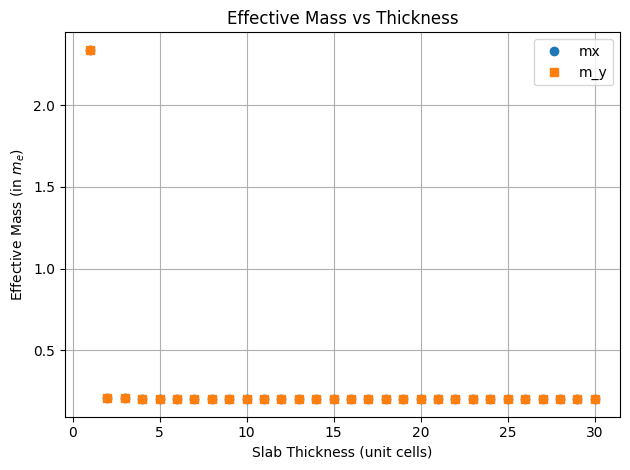

In [30]:
import numpy as np
import matplotlib.pyplot as plt
mxx = np.array([val[0,0] for val in effectiveMassData])
myy = np.array([val[1,1] for val in effectiveMassData])
thickness = np.array([i for i in range (1,31)])

plt.figure()
plt.plot(thickness, mxx, 'o', label='mx')
plt.plot(thickness, myy, 's', label='m_y')
plt.xlabel('Slab Thickness (unit cells)')
plt.ylabel('Effective Mass (in $m_e$)')
plt.title('Effective Mass vs Thickness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
